In [7]:
##加载模型
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
import random
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("detected_model")
model = AutoModelForCausalLM.from_pretrained("detected_model", torch_dtype=torch.bfloat16).to(device)

In [8]:
#加载数据集
import os
os.environ['TOKENIZERS_PARALLELISM'] = "True"
flatten = lambda l : [x for s in l for x in s]
shuffle = lambda l : random.sample(l, k=len(l))
data_path='dataset/valid.json'
print("loading from json...")
with open(data_path, 'r',encoding = 'utf-8') as f:
    data = f.read()
    lines=json.loads(data)
tokens=[d['text'] for d in lines]
print(lines[0].keys())

loading from json...
dict_keys(['text', 'label'])


In [9]:
#计算困惑度
model.eval()
token=tokens[0]
token_len=len(token)
input_ids=tokenizer.encode(token,return_tensors='pt')
#print(input_ids)
nlls=[]#存储每个片段的负对数似然值
prev_end_loc=0#上一个片段的结束位置
stride=30#这个地方应该可以调的
max_length=40#这个地方也可以调

In [22]:

for begin_loc in tqdm(range(0,token_len,stride)):
    end_loc=min(begin_loc+max_length,token_len)
    if end_loc==token_len:
        break
    trg_len=end_loc-prev_end_loc
    input=input_ids[:,begin_loc:end_loc].to(device)
    with torch.no_grad():
        outputs=model(input_ids,labels=input_ids)
        log_likelihood=outputs.loss
    nlls.append(log_likelihood)
    prev_end_loc=end_loc
ppl=torch.exp(torch.stack(nlls).mean())
print("perplexity:",ppl)

  0%|          | 0/130 [00:00<?, ?it/s]

 99%|█████████▉| 129/130 [1:00:13<00:28, 28.01s/it]

perplexity: tensor(8.6250, dtype=torch.bfloat16)


In [12]:
sum_perplexity=[]
for i in range(len(lines)):
    # 输入句子
    # sentence = tokens[i]
    sentence = lines[i]['text']

    # 将句子分词并转换为模型的输入格式
    input_ids = tokenizer.encode(sentence, return_tensors='pt').to(device)

    # 使用模型预测每个词的概率
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    # 计算困惑度
    perplexity = torch.exp(loss)
    sum_perplexity.append({
        'text': sentence,
        'label': lines[i]['label'],
        'perplexity': perplexity.item()
    })
    # sum_perplexity.append(perplexity.item())

# with open('perplexity.json', 'w') as f:
#     json.dump(sum_perplexity, f)
with open('perplexity.json', 'w', encoding='utf-8') as f:
    json.dump(sum_perplexity, f, indent=4, ensure_ascii=False)


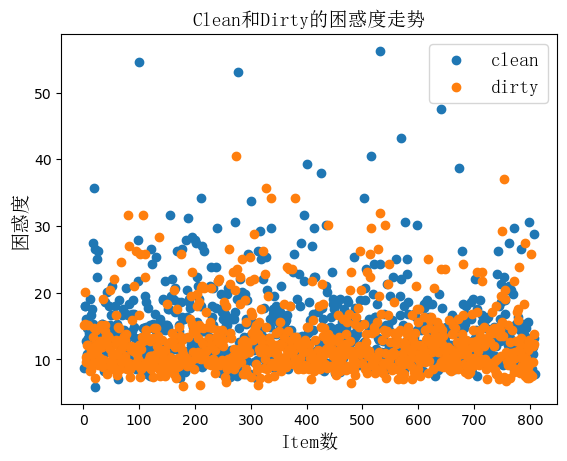

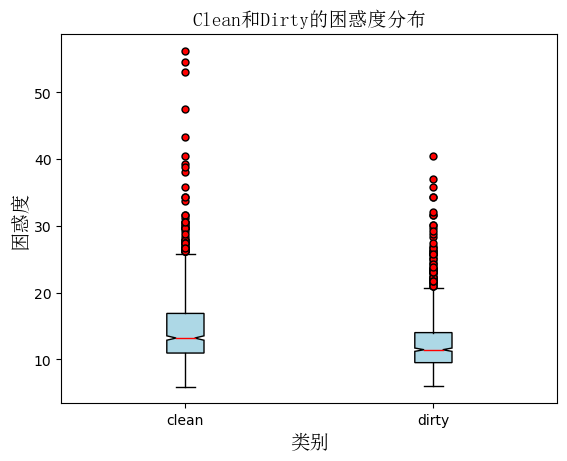

In [22]:
import matplotlib.pyplot as plt
import json
from matplotlib.font_manager import FontProperties
import numpy as np
# 指定字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

# 加载你的数据
with open('perplexity.json','r',encoding='utf-8') as f:
    data = json.load(f)

# 将数据分为clean和dirty两部分
data_clean = [d for d in data if d['label'] == 'clean']
data_dirty = [d for d in data if d['label'] == 'dirty']

# 提取perplexity值
perplexity_clean = [d['perplexity'] for d in data_clean]
perplexity_dirty = [d['perplexity'] for d in data_dirty]

# # 创建横坐标值
# items_clean = list(range(1, len(perplexity_clean) + 1))
# items_dirty = list(range(1, len(perplexity_dirty) + 1))

# # 绘制折线图
# plt.plot(items_clean, perplexity_clean, label='clean')
# plt.plot(items_dirty, perplexity_dirty, label='dirty')

# plt.xlabel('Item数', fontproperties=font)
# plt.ylabel('困惑度', fontproperties=font)
# plt.title('Clean和Dirty的困惑度走势', fontproperties=font)
# plt.legend(prop=font)

# plt.show()
# 创建横坐标值
# items_clean = np.arange(1, len(perplexity_clean) + 1)
# items_dirty = np.arange(1, len(perplexity_dirty) + 1)

# # 定义柱子的宽度
# width = 0.35

# # 绘制柱状图
# plt.bar(items_clean - width/2, perplexity_clean, width, label='clean')
# plt.bar(items_dirty + width/2, perplexity_dirty, width, label='dirty')

# plt.xlabel('Item数', fontproperties=font)
# plt.ylabel('困惑度', fontproperties=font)
# plt.title('Clean和Dirty的困惑度走势', fontproperties=font)
# plt.legend(prop=font)

# plt.show()
# 创建横坐标值
items_clean = np.arange(1, len(perplexity_clean) + 1)
items_dirty = np.arange(1, len(perplexity_dirty) + 1)

# 绘制散点图
plt.scatter(items_clean, perplexity_clean, label='clean')
plt.scatter(items_dirty, perplexity_dirty, label='dirty')

plt.xlabel('Item数', fontproperties=font)
plt.ylabel('困惑度', fontproperties=font)
plt.title('Clean和Dirty的困惑度走势', fontproperties=font)
plt.legend(prop=font)

plt.show()
# 创建数据列表
data_list = [perplexity_clean, perplexity_dirty]

# 创建标签列表
labels = ['clean', 'dirty']

# 绘制箱线图
box = plt.boxplot(data_list, labels=labels, notch=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='black'),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'),
                  medianprops=dict(color='red'),
                  flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'))

plt.xlabel('类别', fontproperties=font)
plt.ylabel('困惑度', fontproperties=font)
plt.title('Clean和Dirty的困惑度分布', fontproperties=font)

plt.show()

### Copilot:
如果你想比较两个变量（在这里是"clean"和"dirty"）对应的困惑度是否存在分布大小的差距，你可以使用统计检验。一个常用的方法是使用t检验，它可以检验两个独立样本的均值是否存在显著差异。

以下是如何使用Python的scipy库进行t检验的示例：

这段代码首先提取出"clean"和"dirty"的perplexity值，然后使用这些值进行t检验。最后，它打印出t统计量和p值。

如果p值小于0.05（或你选择的其他显著性水平），那么你可以拒绝原假设（即两个样本的均值相等），并得出结论：两个样本的均值存在显著差异。否则，你不能拒绝原假设，即不能得出两个样本的均值存在显著差异的结论。

In [17]:
from scipy import stats

# 提取perplexity值
perplexity_clean = [d['perplexity'] for d in data if d['label'] == 'clean']
perplexity_dirty = [d['perplexity'] for d in data if d['label'] == 'dirty']

# 进行t检验
t_stat, p_val = stats.ttest_ind(perplexity_clean, perplexity_dirty)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
# result:
# t-statistic: 7.931112817260807
# p-value: 4.021347489755902e-15


t-statistic: 7.931112817260807
p-value: 4.021347489755902e-15


### Copilot:
如果你想判断"dirty"的困惑度是否显著小于"clean"的困惑度，你可以使用单尾t检验。在scipy的ttest_ind函数中，这可以通过设置alternative参数为'less'来实现。

以下是如何进行单尾t检验的示例：

这段代码进行了一个单尾t检验，检验"dirty"的困惑度是否显著小于"clean"的困惑度。如果p值小于0.05（或你选择的其他显著性水平），那么你可以拒绝原假设（即"dirty"的困惑度大于或等于"clean"的困惑度），并得出结论："dirty"的困惑度显著小于"clean"的困惑度。否则，你不能拒绝原假设，即不能得出"dirty"的困惑度显著小于"clean"的困惑度的结论。

In [18]:
# 进行单尾t检验
t_stat, p_val = stats.ttest_ind(perplexity_dirty, perplexity_clean, alternative='less')

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
# result:
# t-statistic: -7.931112817260807
# p-value: 2.010673744877951e-15

t-statistic: -7.931112817260807
p-value: 2.010673744877951e-15
